# R demo for the 2018 BHI & BSN Data Challenge

This notebook provides a simple introduction to analysing the MIMIC-III database. It was created as a demonstrator for the [2018 BHI & BSN Data Challenge](https://mimic.physionet.org/events/bhibsn-challenge/), which explores the following question:

> Are patients admitted to the intensive care unit (ICU) on a weekend more likely to die in the hospital than those admitted on a weekday?

We have provided an example slide template for final presentations (`slide-template.pptx`) at: https://github.com/MIT-LCP/bhi-bsn-challenge. There is no obligation to use it!

## Background on MIMIC-III

MIMIC-III (‘Medical Information Mart for Intensive Care’) is a large, single-center database comprising information relating to patients admitted to critical care units at a large tertiary care hospital. 

Data includes vital signs, medications, laboratory measurements, observations and notes charted by care providers, fluid balance, procedure codes, diagnostic codes, imaging reports, hospital length of stay, survival data, and more. 

For details, see: https://mimic.physionet.org/. The data is downloaded as 26 CSV files, which can then be loaded into a database system. Scripts for loading the data into Postgres are provided in the [MIMIC Code Repository](https://mimic.physionet.org/gettingstarted/dbsetup/). A demo dataset is also available: https://mimic.physionet.org/gettingstarted/demo/

Points to note:

- A patient-level shift has been applied to dates. Day of week is retained. 
- Patients aged >89 years on first admission have been reassigned an age of ~300 years.
- Patients may have multiple hospital admissions. Each hospital admission may comprise multiple ICU stays (e.g. a patient may visit the ICU, leave for surgery, and then return to the ICU for recovery, all within a single hospital admission).

If you need help getting set up with access to MIMIC-III, please contact `data-challenge@physionet.org`.

## Connect to the MIMIC-III database

The toughest part is often getting the database running and the software connecting to it.  This is the way I usually do it:

1. run `echo 'password' > .pwfile_`
   in a command prompt, where `password` is replaced with your user's postgres password
2. Run this script in the same directory as this file

The resulting chunk may install some R packages on your computer.

In [1]:
if(!("dplyr" %in% installed.packages()) |!("dbplyr" %in% installed.packages()) | !("RPostgreSQL" %in% installed.packages()))  { 
    install.packages(c("dplyr","dbplyr","RPostgreSQL"))
}

                     
library(dplyr); library(dbplyr); library(RPostgreSQL); library(DBI)

# Create a database connection
user <- 'jraffa'
host <- '127.0.0.1'
dbname <- 'mimic'
schema <- 'mimiciii,public'
port <- 5455
passwd <- readLines("~/.pwfile_")

pg_src <- src_postgres(dbname = dbname, 
                       host = host, port = port, 
                       user = user, password = passwd,
                       options=paste0("-c search_path=", schema))

m <- dbDriver("PostgreSQL")
con <- dbConnect(m, user=user, password=passwd, dbname=dbname,host=host,port=port) # The trickiest parts
dbSendStatement(con,paste0("SET search_path TO ",schema))


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘dbplyr’

The following objects are masked from ‘package:dplyr’:

    ident, sql

Loading required package: DBI


<PostgreSQLResult>

In [2]:
# Run query and assign the results to a DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics


# To get these views, the following may work (uncomment to run):
## NOTE:
## This will overwrite old views on your machine if you had already created them.
## If you have them already, you likely do not need to run this code!.
## This will take a while, possibly several hours, depending on the speed of your computer/network
#
#
## if(!("MIMICutil" %in% installed.packages())) { devtools::install_github("jraffa/MIMICutil") }
## 
## library(MIMICutil); library(RPostgreSQL)
## v <- get_views(URLlist="https://raw.githubusercontent.com/jraffa/MIMICutil/master/mat_view_urls_working",dplyrDB=pg_src,con=con)

###

query = "
WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, 
      s.first_careunit
    FROM icustay_detail i
    LEFT JOIN icustays s
    ON i.icustay_id = s.icustay_id
    WHERE i.hospstay_seq = 1
      AND i.icustay_seq = 1
      AND i.age >= 16
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN oasis o
ON f.icustay_id = o.icustay_id;
"

rs <- dbSendQuery(con,query)
dat <- dbFetch(rs)

# or using dplyr:
# uncomment below
#
## icustay_detail_tbl <- tbl(pg_src,"icustay_detail")
## icustays_tbl <- tbl(pg_src,"icustays")
## oasis_tbl  <- tbl(pg_src,"oasis")
##
## first_icu_tbl <- icustay_detail_tbl %>%  select(subject_id,hadm_id, icustay_id, gender,admittime_hospital=admittime,  
##      dischtime_hospital=dischtime, los_hospital, admission_type, 
##   hospital_expire_flag,intime_icu=intime,  outtime_icu=outtime, los_icu,age,hospstay_seq,icustay_seq) %>% 
## left_join(icustays_tbl %>% select(icustay_id, first_careunit) ,by="icustay_id") %>% 
##                filter(hospstay_seq==1,icustay_seq ==1,age>=16) %>% select(-hospstay_seq,-icustay_seq)

## dat <- first_icu_tbl %>% 
##    left_join(oasis_tbl %>% select(icustay_id,icustay_expire_flag, oasis, oasis_prob),by="icustay_id") %>% 
##    collect(n=Inf)

# Check Data Extracted

Always a good idea to inspect the data after you have extracted it.  We will look at the first six patients (rows), and then check the number of rows, and get some summary statistics of the dataset.

In [3]:
# Have a look at the dataset:
head(dat)

nrow(dat) #38557

summary(dat)

subject_id,hadm_id,icustay_id,gender,admittime_hospital,dischtime_hospital,los_hospital,age,admission_type,hospital_expire_flag,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob
3,145834,211552,M,2101-10-20 19:08:00,2101-10-31 13:58:00,10.7847,76.5268,EMERGENCY,0,2101-10-20 19:10:11,2101-10-26 20:43:09,6.0646,MICU,0,57,0.748927417
6,107064,228232,F,2175-05-30 07:15:00,2175-06-15 16:00:00,16.3646,65.9407,ELECTIVE,0,2175-05-30 21:30:54,2175-06-03 13:39:54,3.6729,SICU,0,11,0.008391576
9,150750,220597,M,2149-11-09 13:06:00,2149-11-14 10:15:00,4.8813,41.7902,EMERGENCY,1,2149-11-09 13:07:02,2149-11-14 20:52:14,5.3231,MICU,1,35,0.152891534
11,194540,229441,F,2178-04-16 06:18:00,2178-05-11 19:00:00,25.5292,50.1483,EMERGENCY,0,2178-04-16 06:19:32,2178-04-17 20:21:05,1.5844,SICU,0,29,0.077479229
13,143045,263738,F,2167-01-08 18:43:00,2167-01-15 15:15:00,6.8556,39.8661,EMERGENCY,0,2167-01-08 18:44:25,2167-01-12 10:43:31,3.6660,CCU,0,34,0.137098607
17,194023,277042,F,2134-12-27 07:15:00,2134-12-31 16:05:00,4.3681,47.4543,ELECTIVE,0,2134-12-27 16:21:48,2134-12-29 18:04:03,2.0710,CSRU,0,38,0.209225538


[1] 38557

   subject_id       hadm_id         icustay_id        gender         
 Min.   :    3   Min.   :100001   Min.   :200003   Length:38557      
 1st Qu.:13980   1st Qu.:124930   1st Qu.:225240   Class :character  
 Median :27912   Median :150093   Median :250275   Mode  :character  
 Mean   :38266   Mean   :150038   Mean   :250222                     
 3rd Qu.:62965   3rd Qu.:175223   3rd Qu.:275288                     
 Max.   :99999   Max.   :199999   Max.   :299999                     
                                                                     
 admittime_hospital            dischtime_hospital             los_hospital     
 Min.   :2100-06-07 19:59:00   Min.   :2100-06-09 17:09:00   Min.   : -0.9451  
 1st Qu.:2125-09-28 09:42:00   1st Qu.:2125-10-08 17:35:00   1st Qu.:  4.0479  
 Median :2150-12-27 04:35:00   Median :2151-01-04 15:50:00   Median :  6.8938  
 Mean   :2150-12-13 00:38:20   Mean   :2150-12-22 22:10:28   Mean   :  9.8973  
 3rd Qu.:2176-05-16 07:15:00   3rd Qu.:2

# Add day of week to DataFrame

If we are going to examine the weekend effect, we need to pull this out of the dataset, as you can see, all we have above are dates.  We will define a weekend, as anytime between Saturday (00:00:00) until Sunday (23:59:59).  The dates above are shifted, and that's why they look odd, but they are matched on the day of week, so this aspect is preserved.

In [4]:
if(!("lubridate" %in% installed.packages())) { install.packages("lubridate")}

library(lubridate)

dat$dow <- as.factor(wday(dat$intime_icu ))
table(dat$dow)
# Convert to text levels
levels(dat$dow) <- c("Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday")
table(dat$dow)

dat$weekend <- dat$dow %in% c("Sunday","Saturday")
table(dat$weekend)


Attaching package: ‘lubridate’

The following object is masked from ‘package:base’:

    date




   1    2    3    4    5    6    7 
3960 6097 6141 5985 5876 6263 4235 


   Sunday    Monday   Tuesday Wednesday  Thursday    Friday  Saturday 
     3960      6097      6141      5985      5876      6263      4235 


FALSE  TRUE 
30362  8195 

# Produce some Summary Statistics by DOW and Weekday vs. Weekend

Next, it's good to look at some basic summaries of the data.  We will compute simple averages and percentages/counts for each of the variables we have extracted, and look at it by day of week (`dow`) and weekend (`weekend`).


In [5]:
#If this fails, you may have to install pkg-config and libnlopt-dev on your system
# e.g., in Ubuntu/Debian:
# sudo apt-get install pkg-config  libnlopt-dev

if(!("tableone" %in% installed.packages())) { install.packages("tableone")}

library(tableone)

vars <- c('gender', 'los_hospital', 'age', 'admission_type', 'hospital_expire_flag', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit')

group_var <- "dow"

CreateTableOne(dat,vars=vars,strata=group_var,factorVars=c("hospital_expire_flag","icustay_expire_flag")) %>% 
      print(
  printToggle      = FALSE,
  showAllLevels    = TRUE,
  cramVars         = "kon"
) %>% 
{data.frame(
  variable_name             = gsub(" ", " ", rownames(.), fixed = TRUE), ., 
  row.names        = NULL, 
  check.names      = FALSE, 
  stringsAsFactors = FALSE)} 


variable_name,level,Sunday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,p,test
n,,3960,6097,6141,5985,5876,6263,4235,,
gender (%),F,1736 (43.8),2559 (42.0),2671 (43.5),2636 (44.0),2603 (44.3),2662 (42.5),1857 (43.8),0.097,
,M,2224 (56.2),3538 (58.0),3470 (56.5),3349 (56.0),3273 (55.7),3601 (57.5),2378 (56.2),,
los_hospital (mean (sd)),,9.82 (10.70),9.71 (9.92),9.86 (10.58),9.77 (10.22),9.88 (10.90),10.23 (11.61),10.00 (10.84),0.141,
age (mean (sd)),,75.26 (60.66),73.13 (51.37),75.48 (55.22),74.16 (53.88),75.51 (55.46),74.56 (53.22),73.92 (58.58),0.167,
admission_type (%),ELECTIVE,101 ( 2.6),1265 (20.7),1292 (21.0),1243 (20.8),999 (17.0),1016 (16.2),162 ( 3.8),<0.001,
,EMERGENCY,3681 (93.0),4687 (76.9),4704 (76.6),4600 (76.9),4746 (80.8),5118 (81.7),3852 (91.0),,
,URGENT,178 ( 4.5),145 ( 2.4),145 ( 2.4),142 ( 2.4),131 ( 2.2),129 ( 2.1),221 ( 5.2),,
hospital_expire_flag (%),0,3388 (85.6),5468 (89.7),5491 (89.4),5350 (89.4),5202 (88.5),5576 (89.0),3658 (86.4),<0.001,
,1,572 (14.4),629 (10.3),650 (10.6),635 (10.6),674 (11.5),687 (11.0),577 (13.6),,


In [6]:
vars <- c('gender', 'los_hospital', 'age', 'admission_type', 'hospital_expire_flag', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit')

group_var <- "weekend"

CreateTableOne(dat,vars=vars,strata=group_var,factorVars=c("hospital_expire_flag","icustay_expire_flag")) %>% 
      print(
  printToggle      = FALSE,
  showAllLevels    = TRUE,
  cramVars         = "kon"
) %>% 
{data.frame(
  variable_name             = gsub(" ", " ", rownames(.), fixed = TRUE), ., 
  row.names        = NULL, 
  check.names      = FALSE, 
  stringsAsFactors = FALSE)} 

variable_name,level,FALSE,TRUE,p,test
n,,30362,8195,,
gender (%),F,13131 (43.2),3593 (43.8),0.341,
,M,17231 (56.8),4602 (56.2),,
los_hospital (mean (sd)),,9.89 (10.67),9.91 (10.77),0.879,
age (mean (sd)),,74.56 (53.84),74.57 (59.59),0.997,
admission_type (%),ELECTIVE,5815 (19.2),263 ( 3.2),<0.001,
,EMERGENCY,23855 (78.6),7533 (91.9),,
,URGENT,692 ( 2.3),399 ( 4.9),,
hospital_expire_flag (%),0,27087 (89.2),7046 (86.0),<0.001,
,1,3275 (10.8),1149 (14.0),,


It looks like there's a higher rate of hospital mortality (14.0% vs 10.8%) and ICU mortality (10.2% vs 7.8%) on weekends when compared to weekdays.  There are also statistically significant differences between several other important variables, including: admission type, disease severity (OASIS), and the patient's first care unit, suggesting that these groups may be fundamentally different in some way.  Let's explore this a little further.


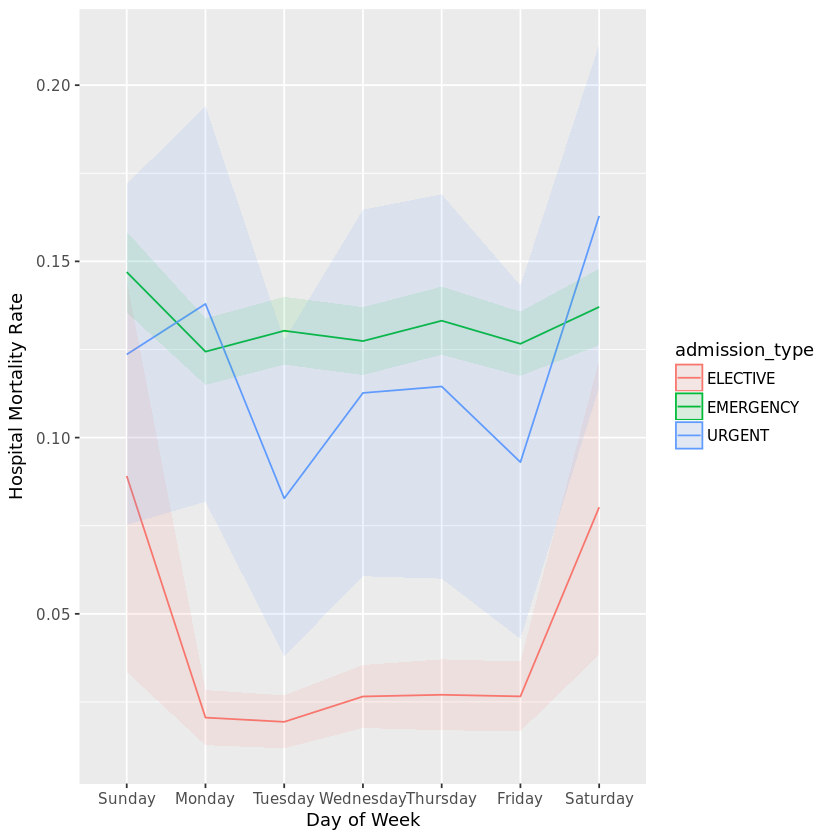

In [7]:
library(ggplot2)

dat %>% group_by(admission_type,dow) %>% 
    summarise(n=n(),mortRate=mean(hospital_expire_flag==1),
              LL95 = mortRate - qnorm(0.975)*sqrt(mortRate*(1-mortRate)/n),
             UL95 = mortRate + qnorm(0.975)*sqrt(mortRate*(1-mortRate)/n)) %>%
    ggplot(aes(dow,mortRate,group=admission_type,col=admission_type)) + 
    geom_line() + 
    geom_ribbon(aes(ymax=UL95,ymin=LL95,fill=admission_type,col=NULL),alpha=0.1) +
    xlab("Day of Week") + ylab("Hospital Mortality Rate")

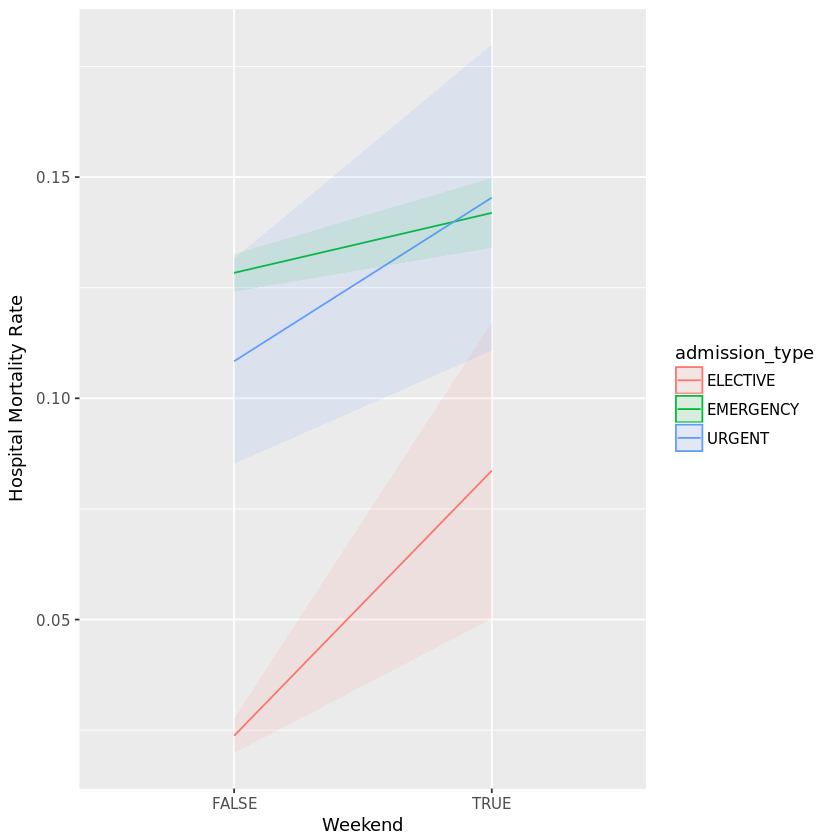

In [8]:
dat$weekend <- as.factor(dat$weekend)
dat$admission_type <- as.factor(dat$admission_type)
dat %>% group_by(admission_type,weekend) %>% 
    summarise(n=n(),mortRate=mean(hospital_expire_flag==1),
              LL95 = mortRate - qnorm(0.975)*sqrt(mortRate*(1-mortRate)/n),
             UL95 = mortRate + qnorm(0.975)*sqrt(mortRate*(1-mortRate)/n)) %>%
    ggplot(aes(weekend,mortRate,group=admission_type,col=admission_type)) + 
    geom_line() + 
    geom_ribbon(aes(ymax=UL95,ymin=LL95,fill=admission_type,col=NULL),alpha=0.1) +
    xlab("Weekend") + ylab("Hospital Mortality Rate")

# Model building

Let's try to incorporate what we saw above into a very simple model. We will use logistic regression with hospital mortality as our outcome. First an unadjusted estimate, and then we will try to adjust for admission type.

The unadjusted analysis should mirror pretty closely what we saw in the one of the tables above.  The odds ratio corresponding with 14.0% and 10.8% mortality in the the weekend and weekday groups, respectively, is about 1.35.  Performing logistic regression on the same data:



Call:
glm(formula = hospital_expire_flag ~ weekend, family = "binomial", 
    data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5497  -0.4778  -0.4778  -0.4778   2.1104  

Coefficients:
            Estimate Std. Error  z value Pr(>|z|)    
(Intercept)  -2.1127     0.0185 -114.204  < 2e-16 ***
weekendTRUE   0.2992     0.0368    8.129 4.33e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 27477  on 38556  degrees of freedom
Residual deviance: 27413  on 38555  degrees of freedom
AIC: 27417

Number of Fisher Scoring iterations: 4


Waiting for profiling to be done...
Warning message:
“Removed 1 rows containing missing values (geom_hline).”

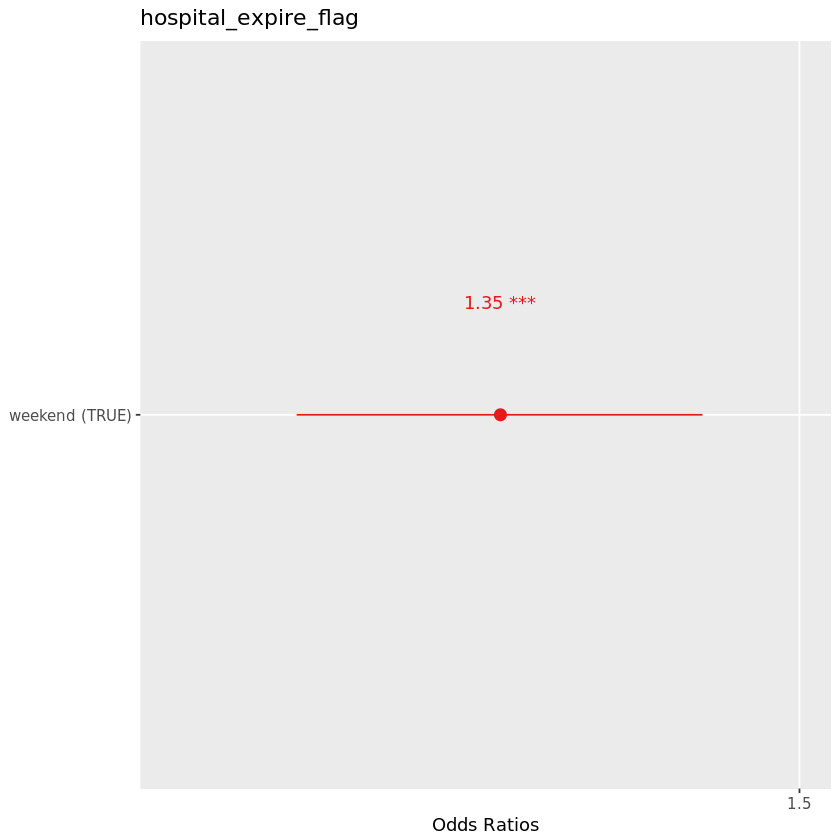

In [9]:
simple.glm <- glm(hospital_expire_flag ~ weekend,data=dat,family="binomial")
summary(simple.glm)

# Uncomment for pretty graph
## if(!("sjPlot" %in% installed.packages())) { install.packages("sjPlot")}
## library(sjPlot)
## sjp.glm(simple.glm)


yields the same results.  The above coefficient for weekend is on the log scale, so when we exponentiate it, we get the odds-ratio: `exp(0.2992) = 1.35`. So, looking at these crude rates and odds ratios, we can see that patients admitted on a weekend have about a 35% increase in the odds of dying in the hospital when compared to those on a weekday. This effect is statistically significant (p<0.001).

Are we done?

I hope not. We saw from the tables and figures above, there is likely some confounding and maybe even effect modification happening. Next let's look at admission type and weekend ICU admission in the same model.  There are two such models we could consider.  The first adjusts for admission type, but assumes that the effect of weekend admission is the same regardless if the patient is of any of the admission types.  The second one adjusts for admission type, but then allows the effect of weekend ICU admission to vary across the different levels of admission type.  The first type of model would be able to account for confounding (when a nuisance variable is associated with both the outcome and the exposure/variable of interest), while the second permits what is called effect modification or a statistical interaction.  Interactions are sometimes difficult to understand, but if ignored, can lead to incorrect conclusions about the effect of one or more of the variables.

In this example, we fit both models, output estimates of the log-odds ratios, and perform a hypothesis test which evaluates the statistical significance of dropping one of the variables.  Below is the resulting output:

In [10]:
# Without effect modification
adj.glm <- glm(hospital_expire_flag ~ weekend + admission_type,data=dat,family="binomial")
summary(adj.glm)
drop1(adj.glm,test="Chisq")

# With effect modification (interaction)
adj.int.glm <- glm(hospital_expire_flag ~ weekend*admission_type,data=dat,family="binomial")
summary(adj.int.glm)
drop1(adj.int.glm,test="Chisq")


Call:
glm(formula = hospital_expire_flag ~ weekend + admission_type, 
    family = "binomial", data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5587  -0.5224  -0.5224  -0.2302   2.6995  

Coefficients:
                        Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.61725    0.08014 -45.137  < 2e-16 ***
weekendTRUE              0.14442    0.03715   3.887 0.000101 ***
admission_typeEMERGENCY  1.69439    0.08221  20.610  < 2e-16 ***
admission_typeURGENT     1.58810    0.12308  12.903  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 27477  on 38556  degrees of freedom
Residual deviance: 26721  on 38553  degrees of freedom
AIC: 26729

Number of Fisher Scoring iterations: 6


,Df,Deviance,AIC,LRT,Pr(>Chi)
<none>,NA,26721.01,26729.01,NA,NA
weekend,1,26735.87,26741.87,14.85949,1.158241e-04
admission_type,2,27412.85,27416.85,691.83845,5.877446e-151



Call:
glm(formula = hospital_expire_flag ~ weekend * admission_type, 
    family = "binomial", data = dat)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5605  -0.5242  -0.5242  -0.2192   2.7353  

Coefficients:
                                    Estimate Std. Error z value Pr(>|z|)    
(Intercept)                         -3.71692    0.08615 -43.143  < 2e-16 ***
weekendTRUE                          1.32317    0.23880   5.541 3.01e-08 ***
admission_typeEMERGENCY              1.80138    0.08830  20.401  < 2e-16 ***
admission_typeURGENT                 1.60954    0.14959  10.760  < 2e-16 ***
weekendTRUE:admission_typeEMERGENCY -1.20715    0.24185  -4.991 6.00e-07 ***
weekendTRUE:admission_typeURGENT    -0.98723    0.30357  -3.252  0.00115 ** 
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 27477  on 38556  degrees of freedom
Residual deviance: 26700  on 38551  degrees

,Df,Deviance,AIC,LRT,Pr(>Chi)
<none>,NA,26700.44,26712.44,NA,NA
weekend:admission_type,2,26721.01,26729.01,20.57385,3.407566e-05


In [ ]:
In the first model (no interaction), we see that although the effect of weekend is almost halved, it remains statistically significant, after adjusting for admission type (p<0.001).

In the second model, we are primarily interested in the significance of the interaction.  We can see when assessed with the `drop1` function, the interaction (`weekend:admission_type`) is statistically significant (p<0.001), suggesting that the effect of weekend may be different depending on which hospital admission type you are.  How exactly to interpret this:

One way of looking at this complexity is by computing the odds ratio in each of the levels of admission type.  We can do this using the `predict` function, which by default outputs the log-odds of death.  If for each hospital admission type, we calculate the log odds of death for each of the levels of weekend,

In [11]:
onWeekend <- expand.grid(weekend="TRUE",admission_type=levels(dat$admission_type))
onWeekday <- expand.grid(weekend="FALSE",admission_type=levels(dat$admission_type))

onWeekend$pred <- predict(adj.int.glm,newdata=onWeekend)
onWeekend 


onWeekday$pred <- predict(adj.int.glm,newdata=onWeekday)
onWeekday 


weekend,admission_type,pred
TRUE,ELECTIVE,-2.393754
TRUE,EMERGENCY,-1.799525
TRUE,URGENT,-1.771439


weekend,admission_type,pred
FALSE,ELECTIVE,-3.716925
FALSE,EMERGENCY,-1.915548
FALSE,URGENT,-2.107381


 We can now compute the log odds ratio ($log(OR) =  logOdds_{weekend} - logOdds_{weekday}$), and exponentiate to get the odds ratio:


In [12]:
onWeekend %>% inner_join(onWeekday,by="admission_type") %>% mutate(OR=exp((pred.x-pred.y)))


weekend.x,admission_type,pred.x,weekend.y,pred.y,OR
TRUE,ELECTIVE,-2.393754,FALSE,-3.716925,3.755307
TRUE,EMERGENCY,-1.799525,FALSE,-1.915548,1.123022
TRUE,URGENT,-1.771439,FALSE,-2.107381,1.399257


 So, this mirrors what we saw above. While there may be differences between `EMERGENCY` and `URGENT` admission types, an `ELECTIVE` admission occurring on a weekend has an odds of mortality almost four times that of an `ELECTIVE` admission on a weekday.  This seems particularly odd -- patients usually do not get admitted to a hospital electively on a weekend. 

 What do you think? 

 Do patients admitted on a weekend have a higher rate of mortality than those admitted during the week? 

 Who is most affected, if at all?

 What factors can you rule out might be causing this effect?  e.g., is it because the patients are simply sicker on a weekend?  Are they more likely to have complications?

 Looking forward to see what you guys come up with!